#  生徒の成績がどの要因と関係しているのか分析した
データの中身 : 性別、人種・民族、親の教育水準、昼食の種類、テスト対策コースの受講の有無、数学の点数、読解の点数、筆記の点数

In [11]:
import scikit_posthocs as sp  #スティール・ドゥワス検定に使用
from scipy import stats #シャピロ・ウィクス検定に使用(正規分布に従っているか確認)
from PIL import Image #画像を挿入する際に使用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
import japanize_matplotlib 
from sklearn.linear_model import LinearRegression #線形回帰を行う際に使用
import seaborn as sns
import pymc as pm
import arviz as az
import bambi as bmb

data = pd.read_csv('/Users/shimizushota/python/StudentsPerformance.csv')
data.info() #データの中身をチェック
print(data.describe()) #Rのsummaryと似ている
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000  

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


math mean = 66.089
reading mean = 69.169
writing mean = 68.054
math median = 66.0
reading median = 70.0
writing median = 69.0
math max = 100
reading max = 100
writing max = 100
math min = 0
reading min = 17
writing min = 10
math sd = 15.163080096009468
reading sd = 14.60019193725222
writing sd = 15.195657010869642
math var = 229.91899799799847
reading var = 213.16560460460474
writing var = 230.9079919919917


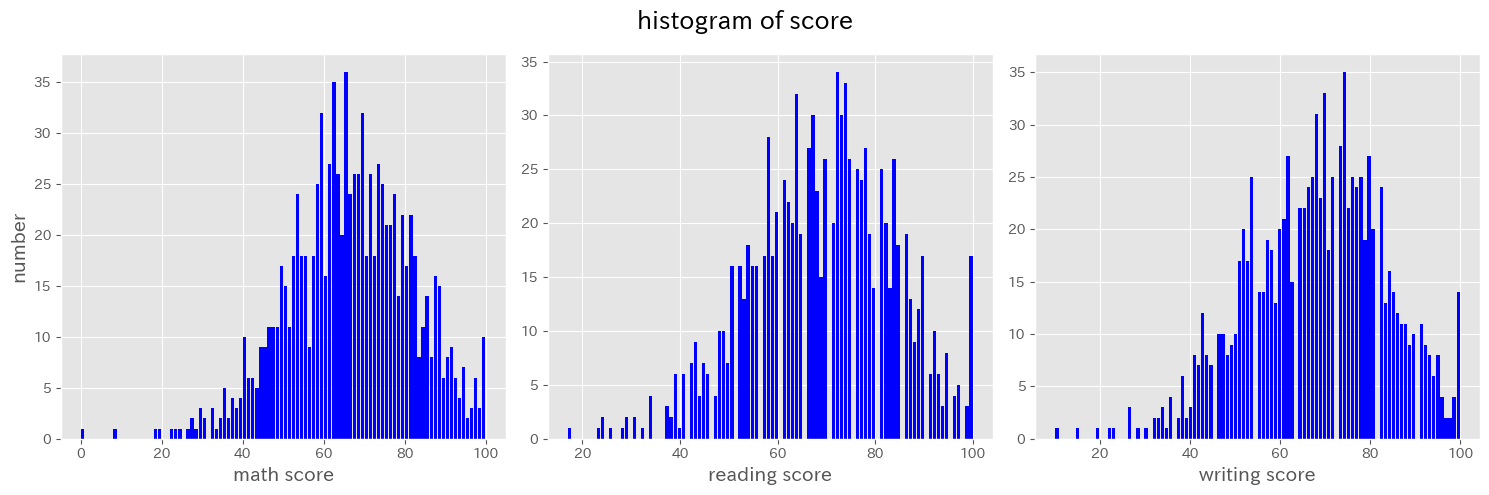

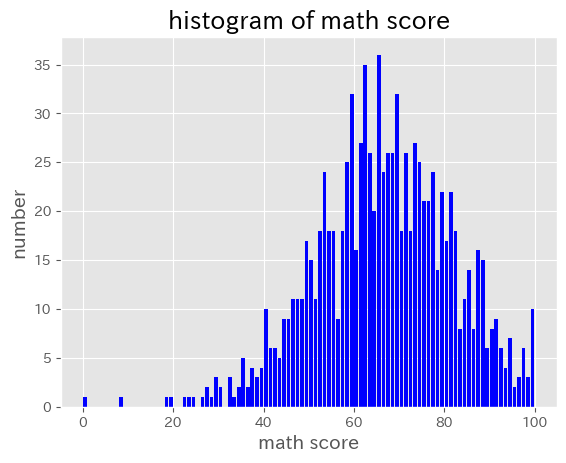

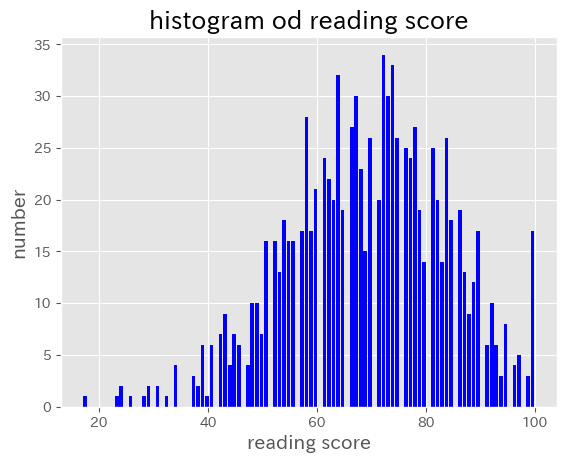

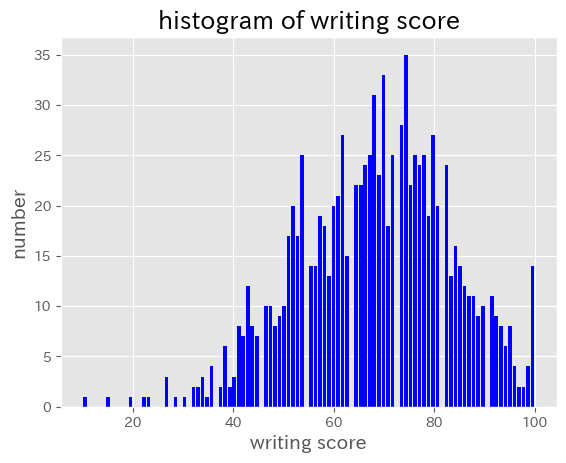

In [17]:
#基本統計量の確認
# 平均値
print(f'math mean = {data['math score'].mean()}')
print(f'reading mean = {data['reading score'].mean()}')
print(f'writing mean = {data['writing score'].mean()}')

#中央値
print(f'math median = {data['math score'].median()}')
print(f'reading median = {data['reading score'].median()}')
print(f'writing median = {data['writing score'].median()}')

#最高点
print(f'math max = {data['math score'].max()}')
print(f'reading max = {data['reading score'].max()}')
print(f'writing max = {data['writing score'].max()}')

#最低点
print(f'math min = {data['math score'].min()}')
print(f'reading min = {data['reading score'].min()}')
print(f'writing min = {data['writing score'].min()}')

#不偏標準偏差
print(f'math sd = {np.std(data['math score'], ddof=1 )}')
print(f'reading sd = {np.std(data['reading score'], ddof=1)}')
print(f'writing sd = {np.std(data['writing score'], ddof=1)}')

#不偏分散
print(f'math var = {np.var(data['math score'], ddof=1)}')
print(f'reading var = {np.var(data['reading score'], ddof=1)}')
print(f'writing var = {np.var(data['writing score'], ddof=1)}')

#3つまとめたヒストグラム
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('histogram of score', fontsize = 18)
ax[0].set_xlabel('math score', fontsize = 14)
ax[0].set_ylabel('number', fontsize = 14)
ax[0].hist(data['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
ax[1].set_xlabel('reading score', fontsize = 14)
ax[1].hist(data['reading score'], bins = 100, rwidth = 0.8 ,color = 'b')
ax[2].set_xlabel('writing score', fontsize = 14)
ax[2].hist(data['writing score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.tight_layout()
plt.show()

#mathのヒストグラム
fig, ax = plt.subplots()
ax.set_title('histogram of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(data['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#readingのヒストグラム
fig, ax = plt.subplots()
ax.set_title('histogram od reading score', fontsize = 18)
ax.set_xlabel('reading score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(data['reading score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#writingのヒストグラム
fig, ax = plt.subplots()
ax.set_title('histogram of writing score', fontsize = 18)
ax.set_xlabel('writing score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(data['writing score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

### 成績と民族の関係
まず各民族の成績の分布を確認するためにヒストグラムの作成を行った。  
次にシュピロ・ウィルク検定を行い、各民族の成績が正規分布に従っているか調べた。   
検定の結果、民族Bの数学・読解・筆記の成績が正規分布に従っていないことが分かったのでノンパラメトリックの多重比較を行った。   

#### 多重比較検定を行った結果
- 数学の点数 : 民族Eは民族A,B,C,Dに対して、民族Dは民族A,Bに対して有意差がある
- 読解の点数 : 民族Eは民族A,B,C,Dに対して、民族Dは民族Cに対して有意差がある
- 筆記の点数 : 民族Eは民族A,Bに対して、民族Dは民族A,Bに対して、民族Cは民族Aに対して有意差がある。
  
以上のことが分かった。  

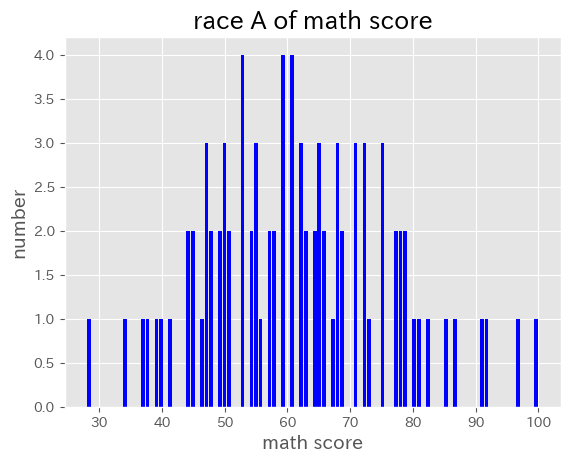

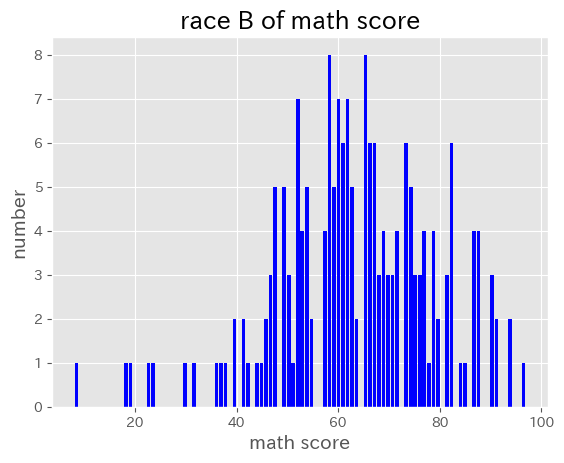

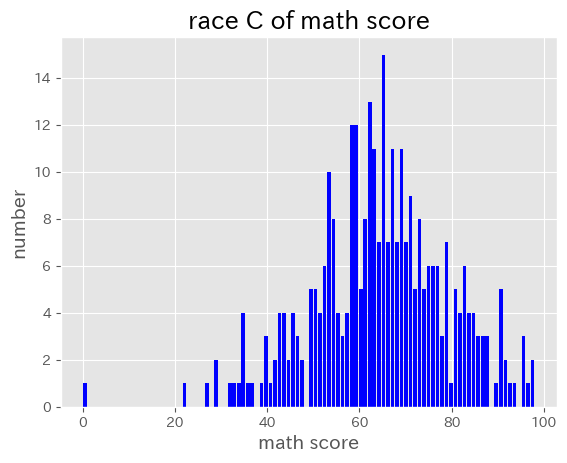

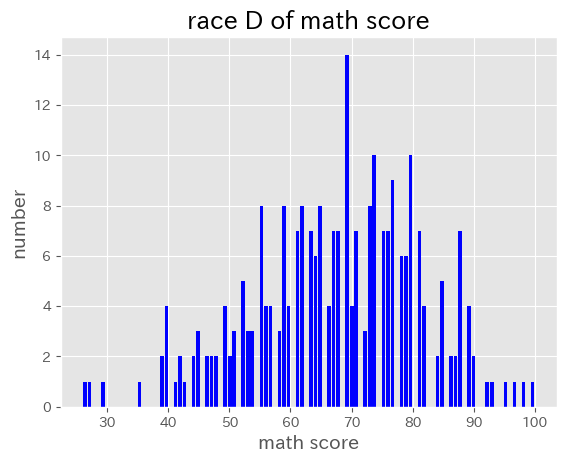

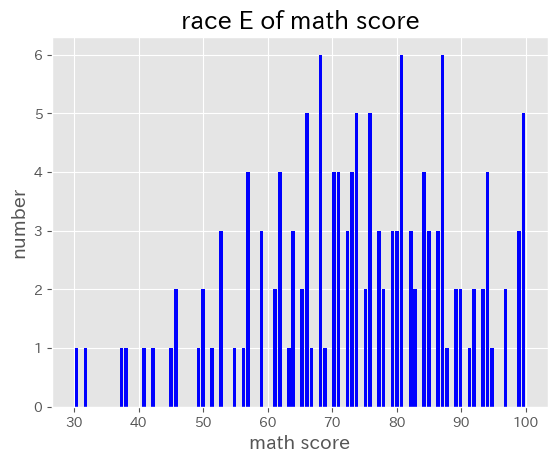

ShapiroResult(statistic=0.9917360440600252, pvalue=0.8545319451008007)
ShapiroResult(statistic=0.9909481406292047, pvalue=0.8038195479730308)
ShapiroResult(statistic=0.9881641456684208, pvalue=0.6042127776865562)
ShapiroResult(statistic=0.9808056990812751, pvalue=0.010389426534437658)
ShapiroResult(statistic=0.9855941806528611, pvalue=0.04912542237846768)
ShapiroResult(statistic=0.9826837378992016, pvalue=0.018961697623682678)
              A             B             C         D             E
A  1.000000e+00  6.569791e-01  3.098548e-01  0.003500  7.541489e-08
B  6.569791e-01  1.000000e+00  9.698695e-01  0.043237  5.129116e-08
C  3.098548e-01  9.698695e-01  1.000000e+00  0.072684  1.313152e-08
D  3.500131e-03  4.323666e-02  7.268380e-02  1.000000  2.059462e-04
E  7.541489e-08  5.129116e-08  1.313152e-08  0.000206  1.000000e+00
          A         B         C         D         E
A  1.000000  0.532755  0.050701  0.022861  0.000465
B  0.532755  1.000000  0.724736  0.431077  0.009714
C  0.

In [25]:
#民族と成績の関係
#民族ごとにデータをまとめた
# grouped_data = {group: data[data['race/ethnicity'] == group] for group in data['race/ethnicity'].unique()}
# grouped_data['group A']のようにするとグループAのデータを取得できる
dataA = data[data['race/ethnicity'] == 'group A']
dataB = data[data['race/ethnicity'] == 'group B']
dataC = data[data['race/ethnicity'] == 'group C']
dataD = data[data['race/ethnicity'] == 'group D']
dataE = data[data['race/ethnicity'] == 'group E']

#民族A　数学のヒストグラム
fig, ax = plt.subplots()
ax.set_title('race A of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(dataA['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#民族B　数学のヒストグラム
fig, ax = plt.subplots()
ax.set_title('race B of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(dataB['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#民族C　数学のヒストグラム
fig, ax = plt.subplots()
ax.set_title('race C of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(dataC['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#民族D　数学のヒストグラム
fig, ax = plt.subplots()
ax.set_title('race D of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(dataD['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#民族E　数学のヒストグラム
fig, ax = plt.subplots()
ax.set_title('race E of math score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(dataE['math score'], bins = 100, rwidth = 0.8 ,color = 'b')
plt.show()

#正規分布に従っているかを調べる　シャピロ・ウィルク検定（今回は95%信頼区間で行ったので p < 0.05だったら棄却され正規分布に従っていないことになる）
#グループAは正規分布に従っていることが分かった
Am = stats.shapiro(dataA['math score'])
Ar = stats.shapiro(dataA['reading score'])
Aw = stats.shapiro(dataA['writing score'])
print(Am)
print(Ar)
print(Aw)

#グループBは正規分布に従っていないことが分かった
Bm = stats.shapiro(dataB['math score'])
Br = stats.shapiro(dataB['reading score'])
Bw = stats.shapiro(dataB['writing score'])
print(Bm)
print(Br)
print(Bw)

#スティール・ドゥワスの多重比較検定　民族間で数学の成績に差があるのか調べる　→　結果から民族Eは民族A,B,C,Dに対して、民族Dは民族A,Bに対して有意差がある
math_compare = pd.DataFrame({'A':dataA['math score'], 'B': dataB['math score'], 'C': dataC['math score']
                             , 'D': dataD['math score'], 'E': dataE['math score']})
math_compare = math_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(math_compare, val_col='values', group_col='groups'))

#スティール・ドゥワスの多重比較検定　民族間でreadingの成績に差があるのか調べる　→ 結果から民族Eは民族A,B,C,Dに対して、民族Dは民族Cに対して有意差がある
reading_compare = pd.DataFrame({'A':dataA['reading score'], 'B': dataB['reading score'], 'C': dataC['reading score']
                             , 'D': dataD['reading score'], 'E': dataE['reading score']})
reading_compare = reading_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(reading_compare, val_col='values', group_col='groups'))

#スティール・ドゥワスの多重比較検定　民族間でwritingの成績に差があるのか調べる　→ 結果から民族Eは民族A,Bに対して、民族Dは民族A,Bに対して、民族Cは民族Aに対して有意差がある
writing_compare = pd.DataFrame({'A':dataA['writing score'], 'B': dataB['writing score'], 'C': dataC['writing score']
                             , 'D': dataD['writing score'], 'E': dataE['writing score']})
writing_compare = writing_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(writing_compare, val_col='values', group_col='groups'))

#まとめ: 一部の民族の成績は他の民族の成績との間に有意差があることが示された。

### 成績と性別の関係
性別でデータを分けてから数学の点数を箱ひげ図にして表示した。   
その後、数学の点数の違いをヒストグラムで視覚的に確認した。   
数値として数学の平均点に違いがあるのか調べるために検定を行った。    

#### 検定の順序は次の通り  
1. シャピロ・ウィルク検定で正規分布に従っているか確認
2. 読解と筆記の得点は正規分布に従っていたので、等分散になっているか確認するためにバーレット検定を実施
3. 等分散になっていなかったのでウェルチのT検定を実施
4. 数学の得点は正規分布に従っていなかったので、マン・ホイットニーのU検定を実施

#### 検定を行った結果     
性別によって成績の平均値や中央値は異なることが示された

     gender race/ethnicity parental level of education         lunch  \
0    female        group B           bachelor's degree      standard   
1    female        group C                some college      standard   
2    female        group B             master's degree      standard   
5    female        group B          associate's degree      standard   
6    female        group B                some college      standard   
..      ...            ...                         ...           ...   
993  female        group D           bachelor's degree  free/reduced   
995  female        group E             master's degree      standard   
997  female        group C                 high school  free/reduced   
998  female        group D                some college      standard   
999  female        group D                some college  free/reduced   

    test preparation course  math score  reading score  writing score  
0                      none          72             72         

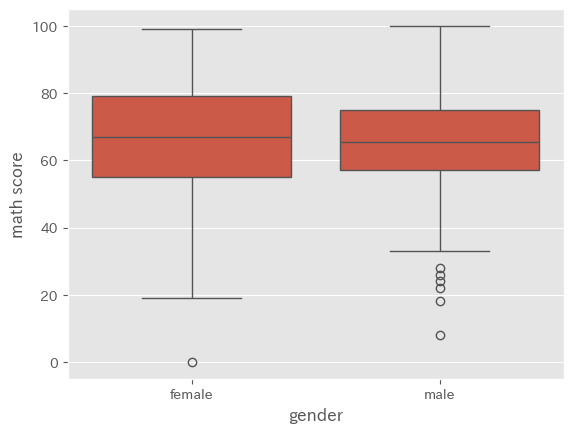

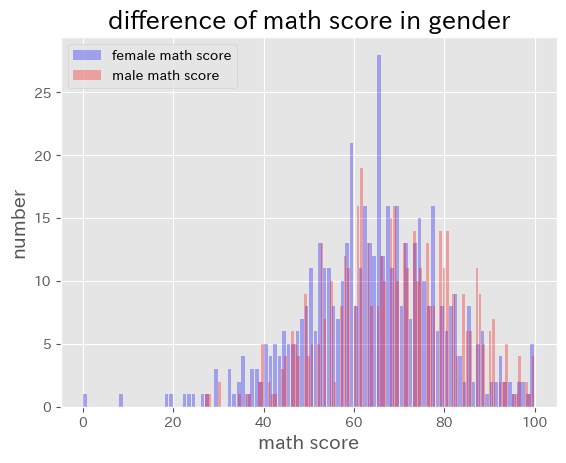

ShapiroResult(statistic=0.9911773367235315, pvalue=0.00350980944548579)
ShapiroResult(statistic=0.9854966514281482, pvalue=4.957654317137049e-05)
ShapiroResult(statistic=0.9792476528450613, pvalue=9.908961375398304e-07)
ShapiroResult(statistic=0.9935648775263688, pvalue=0.03801760848161378)
ShapiroResult(statistic=0.9946232523317922, pvalue=0.089645187109084)
ShapiroResult(statistic=0.9948080618914475, pvalue=0.10401446152420847)
MannwhitneyuResult(statistic=101768.5, pvalue=4.2790767734787687e-07)
BartlettResult(statistic=0.4947914902633937, pvalue=0.4817976802944669)
BartlettResult(statistic=1.2674241946116256, pvalue=0.26025045596080293)
TtestResult(statistic=7.9683565184844, pvalue=4.3762967534977204e-15, df=996.3597383234206)
TtestResult(statistic=9.997718973491885, pvalue=1.711809371849699e-22, df=997.534347771568)


In [33]:
#性別と成績の関係 男女で人数が異なることに注意！
data_female = data[data['gender']== 'female']
data_male = data[data['gender'] == 'male']
print(data_female)
print(data_male)
print(data_female.describe())
print(data_male.describe())

# グループごとの平均値を計算
gender_avg_scores = data.groupby('gender')['math score'].mean()
print(gender_avg_scores)

# グループ間の平均値の差を可視化
data_gender = pd.DataFrame( data['gender'], data['math score'])
sns.boxplot(x = 'gender', y = 'math score', data = data_gender)
plt.show()

fig, ax = plt.subplots()
ax.set_title('difference of math score in gender', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('number', fontsize = 14)
ax.hist(data_female['math score'], bins = 100, rwidth = 0.8, color = 'b', alpha = 0.3, label = 'female math score')
ax.hist(data_male['math score'], bins = 100, rwidth = 0.8, color = 'r', alpha = 0.3, label = 'male math score')
plt.legend()
plt.show()

#正規分布に従っているかを調べる　シャピロ・ウィルク検定（今回は95%信頼区間で行ったので p < 0.05だったら棄却され正規分布に従っていないことになる）
Fm = stats.shapiro(data_female['math score'])
Fr = stats.shapiro(data_female['reading score'])
Fw = stats.shapiro(data_female['writing score'])
print(Fm)
print(Fr)
print(Fw)
#math score以外は正規分布に従っていることが分かった

Mm = stats.shapiro(data_male['math score'])
Mr = stats.shapiro(data_male['reading score'])
Mw = stats.shapiro(data_male['writing score'])
print(Mm)
print(Mr)
print(Mw)
#math score以外は正規分布に従っていることが分かった

#マン・ホイットニーのU検定　2群間の中央値に差があるのか調べる　p < 0.05になったので性別で数学の点数の分布が同じでないことや中央値に差があることが示された
print(stats.mannwhitneyu(data_female['math score'], data_male['math score'], alternative = 'two-sided'))

#readingとwritingに関しては正規分布に従っていることが分かったので等分散になっているか調べる 
#バーレット検定
print(stats.bartlett(data_female['reading score'], data_male['reading score']))
print(stats.bartlett(data_female['writing score'], data_male['writing score']))
#等分散になっていなかった

#等分散になっていなかったのでウェルチのT検定を実施する　→ 性別でreading scoreとwriting scoreの平均値に有意な差があることが示された
print(stats.ttest_ind(data_female['reading score'], data_male['reading score'], equal_var = False))
print(stats.ttest_ind(data_female['writing score'], data_male['writing score'], equal_var = False))

#まとめ: 性別によって成績の平均値や中央値は異なることが示された

### 成績と親の教育レベルの関係
#### 親の教育レベルでデータを分けてから次のように検定を行った。   
1. 正規分布に従っているか確認
2. 正規分布に従っていないかったのでスティール・ドゥワス検定と呼ばれるノンパラメトリックの多重比較検定を行った
<br>   
#### 検定の結果 
- 数学 : high schoolとそれ以外(bachelor, master, some college, associate)の間で有意差があった
- 読解 : high schoolとそれ以外(bachelor, master, some college, associate)の間で有意差があった
- 筆記 : high schoolとそれ以外(bachelor, master, some college, associate), masterとsome collegeの間で有意差があった

In [40]:
#親の教育レベルと成績の関係
#parental level of educationで成績に差があるのか調べる
data_bacheor = data[data['parental level of education'] == "bachelor's degree"]
data_master = data[data['parental level of education'] == "master's degree"]
data_some_college = data[data['parental level of education'] == 'some college']
data_associate = data[data['parental level of education'] == "associate's degree"]
data_high_school = data[data['parental level of education'] == 'high school']

#stats.Shapiroで正規分布に従っているか調べる　正規分布になっていなかった
print(stats.shapiro(data_bacheor['math score']))
print(stats.shapiro(data_bacheor['reading score']))
print(stats.shapiro(data_bacheor['writing score']))

print(stats.shapiro(data_master['math score']))
print(stats.shapiro(data_master['reading score']))
print(stats.shapiro(data_master['writing score']))

#スティール・ドゥワスの多重比較検定 
math_degree_compare = pd.DataFrame({'bacheor': data_bacheor['math score'], 'master': data_master['math score'], 
                             'some college': data_some_college['math score'], 'associate': data_associate['math score'], 
                             'high school': data_high_school['math score']})
math_degree_compare = math_degree_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(math_degree_compare, val_col='values', group_col='groups'))
#数学の点数と親の教育レベルの関係を分析した所、high schoolとそれ以外(bachelor, master, some college, associate)の間で有意差があることが示された

#スティール・ドゥワスの多重比較検定 
reading_degree_compare = pd.DataFrame({'bacheor': data_bacheor['reading score'], 'master': data_master['reading score'], 
                             'some college': data_some_college['reading score'], 'associate': data_associate['reading score'], 
                             'high school': data_high_school['reading score']})
reading_degree_compare = reading_degree_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(reading_degree_compare, val_col='values', group_col='groups'))
#読解の点数と親の教育レベルの関係を分析した所、high schoolとそれ以外(bachelor, master, some college, associate)の間で有意差があることが示された

#スティール・ドゥワスの多重比較検定 　high schoolは他の4つと比べて有意差があり、masterはsome collegeと有意差がある
writing_degree_compare = pd.DataFrame({'bacheor': data_bacheor['writing score'], 'master': data_master['writing score'], 
                             'some college': data_some_college['writing score'], 'associate': data_associate['writing score'],
                                       'high school': data_high_school['writing score']})
writing_degree_compare = writing_degree_compare.melt(var_name='groups', value_name='values')
print(sp.posthoc_dscf(writing_degree_compare, val_col='values', group_col='groups'))
#読解の点数と親の教育レベルの関係を分析した所、high schoolとそれ以外(bachelor, master, some college, associate), masterとsome collegeの間で有意差があることが示された

ShapiroResult(statistic=0.9906346684603623, pvalue=0.6043520672152705)
ShapiroResult(statistic=0.9822511015428218, pvalue=0.12172798561643774)
ShapiroResult(statistic=0.9836062192423296, pvalue=0.16142548019784148)
ShapiroResult(statistic=0.9558513883191565, pvalue=0.031722280977426416)
ShapiroResult(statistic=0.9788916200780282, pvalue=0.3946918600206584)
ShapiroResult(statistic=0.979334031483793, pvalue=0.4123520558406505)
               bacheor    master  some college  associate  high school
bacheor       1.000000  0.998625      0.659888   0.880980     0.000818
master        0.998625  1.000000      0.691872   0.917196     0.010706
some college  0.659888  0.691872      1.000000   0.998493     0.008679
associate     0.880980  0.917196      0.998493   1.000000     0.006384
high school   0.000818  0.010706      0.008679   0.006384     1.000000
               bacheor    master  some college  associate  high school
bacheor       1.000000  0.881236      0.371882   0.848850     0.000071
mas

### 成績とlunchの種類の関係
#### 同様に検定を行った結果   
- テストの得点(math/reading/writing)とlunchの種類(standard or free/reduced)との間に有意差がある事が示された

In [46]:
# lunchの種類に応じた成績の変化
data_lunch_std = data[data['lunch'] == 'standard' ]
data_lunch_other = data[data['lunch'] == 'free/reduced']

# stats.shapiro data_lunch_otherが正規分布に従っていない
print(stats.shapiro(data_lunch_std['math score']))
print(stats.shapiro(data_lunch_std['reading score']))
print(stats.shapiro(data_lunch_std['writing score']))

print(stats.shapiro(data_lunch_other['math score']))
print(stats.shapiro(data_lunch_other['reading score']))
print(stats.shapiro(data_lunch_other['writing score']))

# stats.mannwhitneyu　正規分布に従っていないときに中央値で差があるのか検定する　
print(stats.mannwhitneyu(data_lunch_std['math score'], data_lunch_other['math score']))
print(stats.mannwhitneyu(data_lunch_std['reading score'], data_lunch_other['reading score']))
print(stats.mannwhitneyu(data_lunch_std['writing score'], data_lunch_other['writing score']))
#テストの得点(math/reading/writing)とlunchの種類(standard or free/reduced)との間に有意差がある事が示された

ShapiroResult(statistic=0.9944101972006532, pvalue=0.01810979826560764)
ShapiroResult(statistic=0.9925491987630133, pvalue=0.002610354589769796)
ShapiroResult(statistic=0.9907598986781115, pvalue=0.00045603346870348624)
ShapiroResult(statistic=0.9924984858382195, pvalue=0.07164794431936643)
ShapiroResult(statistic=0.9934411874170391, pvalue=0.12592781147996585)
ShapiroResult(statistic=0.9937124969314436, pvalue=0.1478056088397237)
MannwhitneyuResult(statistic=161077.0, pvalue=1.5220418036522966e-26)
MannwhitneyuResult(statistic=144848.0, pvalue=3.694124104212827e-12)
MannwhitneyuResult(statistic=147389.0, pvalue=5.081056223940967e-14)


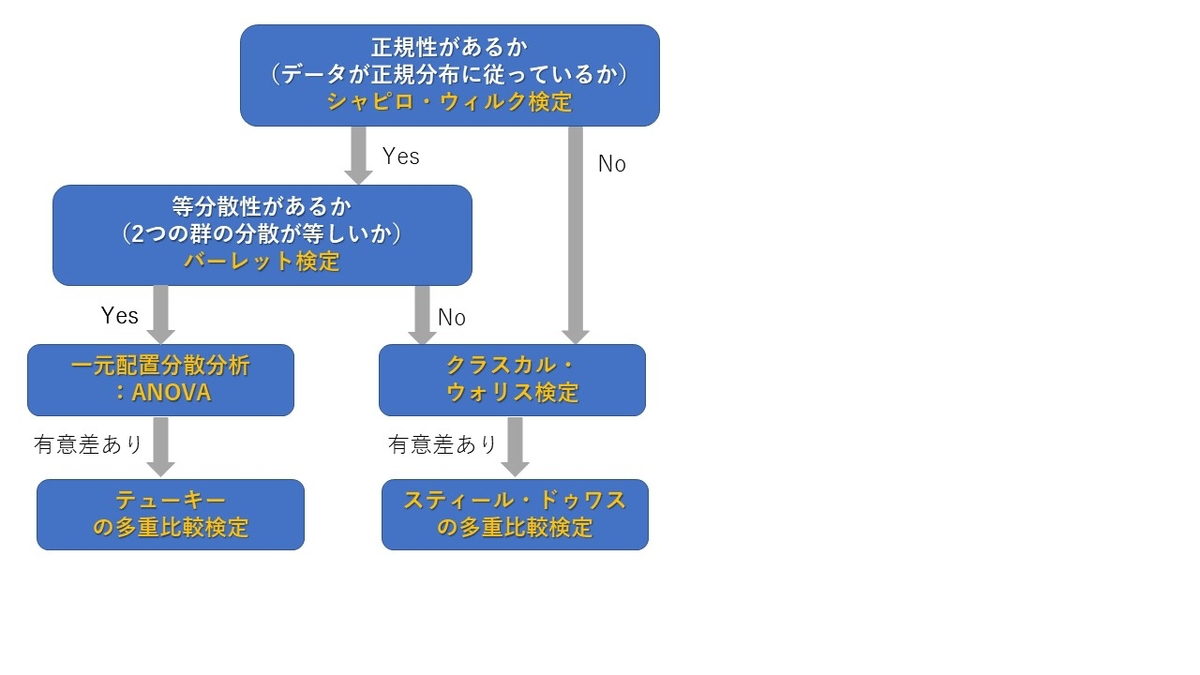

In [49]:
#対応のない３群以上の平均値の差の検定の流れ　参照元: https://chantastu.hatenablog.com/entry/2022/08/27/231918
flow1 = Image.open('/Users/shimizushota/python/20220827222059.jpg')
flow1

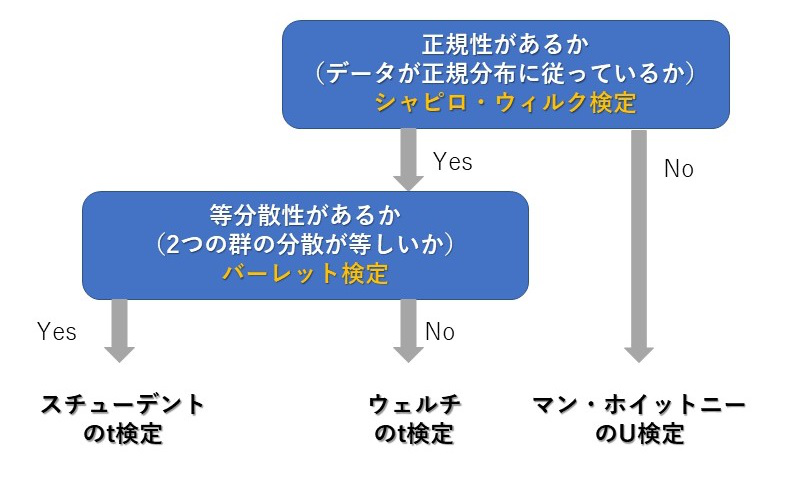

In [52]:
#対応のない２群の平均値の差の検定の流れ　参照元: https://chantastu.hatenablog.com/entry/2022/08/27/175659
flow2 = Image.open('/Users/shimizushota/python/20220827165706.jpg')
flow2

### 成績とテスト対策コースの受講の有無の関係
#### 検定の流れ
1. 正規分布の確認
2. 等分散の確認
3. 等分散の場合はstudentのt検定、そうでない場合はウェルチのt検定
4. 正規分布に従っていない場合、ノンパラメトリックの検定 <br>

#### 検定の結果
- preparation courseの有無によって全ての教科の成績が変化している事が示された

In [58]:
#preparation courseの有無によって成績は変化するのか調べる
data_testpre = data[data['test preparation course'] == 'completed']
data_testno = data[data['test preparation course'] == 'none']

# stats.shapiro 数学以外は正規分布に従っている
print(stats.shapiro(data_testpre['math score']))
print(stats.shapiro(data_testpre['reading score']))
print(stats.shapiro(data_testpre['writing score']))

print(stats.shapiro(data_testno['math score']))
print(stats.shapiro(data_testno['reading score']))
print(stats.shapiro(data_testno['writing score']))

# stats.mannwhitneyu 　→ test preparationをした生徒としない生徒で数学の点数に差がある
print(stats.mannwhitneyu(data_testpre['math score'], data_testno['math score']))

# stats.bartlett　readingとwritingは正規分布だったので等分散であるか調べる　→　writing scoreは等分散
print(stats.bartlett(data_testpre['reading score'], data_testno['reading score']))
print(stats.bartlett(data_testpre['writing score'], data_testno['writing score']))

#ウェルチのt検定　stats.tttest_ind(x, y, equal_var = False) 有意差あり
print(stats.ttest_ind(data_testpre['reading score'], data_testno['reading score'], equal_var = False ))

#studentのt検定　stats.ttest_ind(x, y, equal_var = True)　有意差あり
print(stats.ttest_ind(data_testpre['writing score'], data_testno['writing score'], equal_var = True))

#まとめ: preparation courseの有無によっていずれの教科の成績は変化する事が示された

ShapiroResult(statistic=0.9936613643190316, pvalue=0.1393494159012534)
ShapiroResult(statistic=0.9856341949660862, pvalue=0.0012637476098130188)
ShapiroResult(statistic=0.9855168789628109, pvalue=0.001185711027387102)
ShapiroResult(statistic=0.9921171200614828, pvalue=0.0017542243871882573)
ShapiroResult(statistic=0.9943259030202183, pvalue=0.016996928395028935)
ShapiroResult(statistic=0.9951739757332491, pvalue=0.04211426966082906)
MannwhitneyuResult(statistic=138412.0, pvalue=8.01517403046955e-08)
BartlettResult(statistic=1.56368072820013, pvalue=0.21112710367802134)
BartlettResult(statistic=5.877420784395277, pvalue=0.015336271436165151)
TtestResult(statistic=8.004132353965, pvalue=4.388808024290597e-15, df=775.3693595698406)
TtestResult(statistic=10.409173436808748, pvalue=3.68529173524572e-24, df=998.0)


傾き: [[0.78722924]]
切片: [17.14180679]


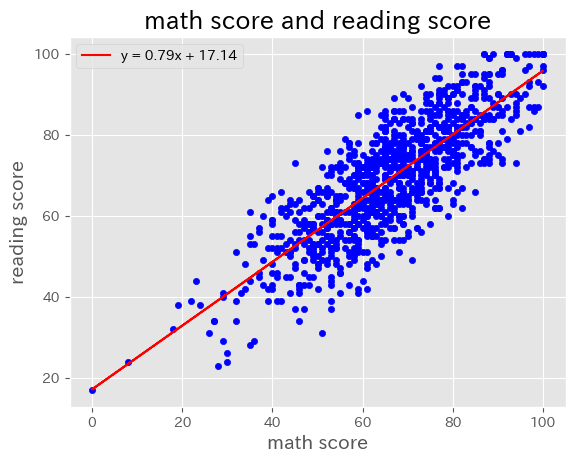

[[1.         0.81757966]
 [0.81757966 1.        ]]
傾き: [[0.80436647]]
切片: [14.89422427]


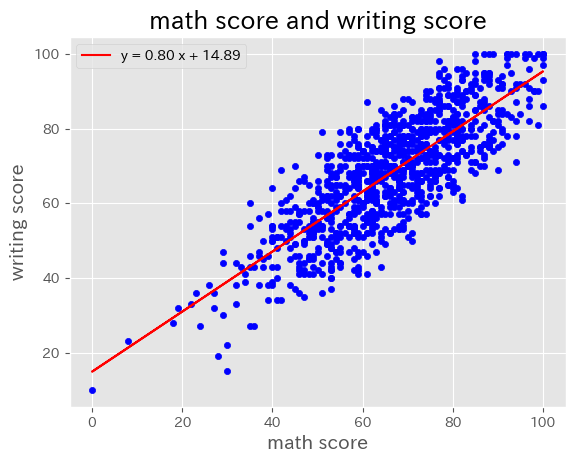

[[1.         0.80264205]
 [0.80264205 1.        ]]
傾き: [[0.91719069]]
切片: [6.75050474]


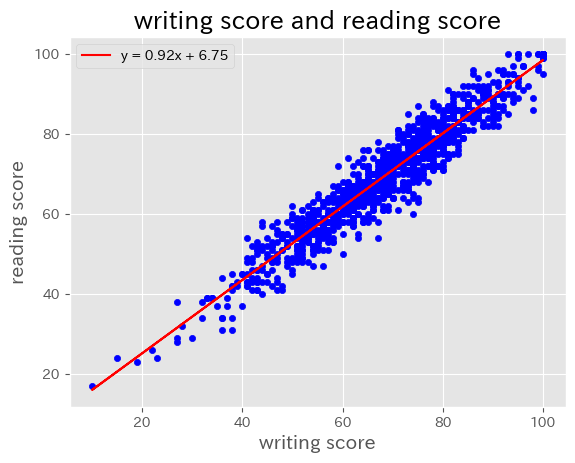

[[1.         0.95459808]
 [0.95459808 1.        ]]


In [63]:
#練習用　
#math scoreとreading scoreの散布図と回帰直線
fig, ax = plt.subplots()
ax.set_title('math score and reading score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('reading score', fontsize = 14)
ax.scatter(data['math score'], data['reading score'], s = 20, color = 'blue')
#線形回帰を作成するモデルにデータを読み込む
x1 = pd.DataFrame(data['math score'])
y1 = pd.DataFrame(data['reading score'])
model1 = LinearRegression()
model1.fit(x1,y1)
print('傾き:', model1.coef_)
print('切片:', model1.intercept_)
ax.plot(x1, model1.predict(x1), label = f'y = {model1.coef_.item():.2f}x + {model1.intercept_.item():.2f}', color = 'red')
plt.legend()
plt.show()
#相関係数を知りたいときにnp.corrcoef()
print(np.corrcoef(data['math score'], data['reading score']))


#math scoreとwriting scoreの散布図と回帰直線
fig, ax = plt.subplots()
ax.set_title('math score and writing score', fontsize = 18)
ax.set_xlabel('math score', fontsize = 14)
ax.set_ylabel('writing score', fontsize = 14)
ax.scatter(data['math score'], data['writing score'], s = 20, color = 'blue')
#線形回帰を作成するモデルにデータを読み込む
x2 = pd.DataFrame(data['math score'])  #線形回帰直線を描くために１列のデータフレームを作成した
y2 = pd.DataFrame(data['writing score'])
model2 = LinearRegression()
model2.fit(x2, y2)
print('傾き:', model2.coef_)
print('切片:', model2.intercept_)
ax.plot(x2, model2.predict(x2), label = f'y = {model2.coef_.item():.2f} x + {model2.intercept_.item():.2f}', color = 'red') 
plt.legend() # item()でnumpy配列のスカラー値を得ている
plt.show()
# np.corrcoef
print(np.corrcoef(data['math score'], data['writing score']))


#writing scoreとreading scoreの散布図と回帰直線
fig, ax = plt.subplots()
ax.set_title('writing score and reading score', fontsize = 18)
ax.set_xlabel('writing score', fontsize = 14)
ax.set_ylabel('reading score', fontsize = 14)
ax.scatter(data['writing score'], data['reading score'], s = 20, color = 'blue')
#線形回帰を作成するモデルにデータを読み込む
x3 = pd.DataFrame(data['writing score'])
y3 = pd.DataFrame(data['reading score'])
model3 = LinearRegression()
model3.fit(x3,y3)
print('傾き:', model3.coef_)
print('切片:', model3.intercept_)
ax.plot(x3, model3.predict(x3), label = f'y = {model3.coef_.item():.2f}x + {model3.intercept_.item():.2f}', color = 'red')
plt.legend()
plt.show()
# np.corrcoef
print(np.corrcoef(data['writing score'], data['reading score']))

### 各教科の相関係数を確認する     
#### 結果    
##### 読解と筆記のテストの相関係数が特に高い値を示した

     math score  reading score  writing score
0            72             72             74
1            69             90             88
2            90             95             93
3            47             57             44
4            76             78             75
..          ...            ...            ...
995          88             99             95
996          62             55             55
997          59             71             65
998          68             78             77
999          77             86             86

[1000 rows x 3 columns]
               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


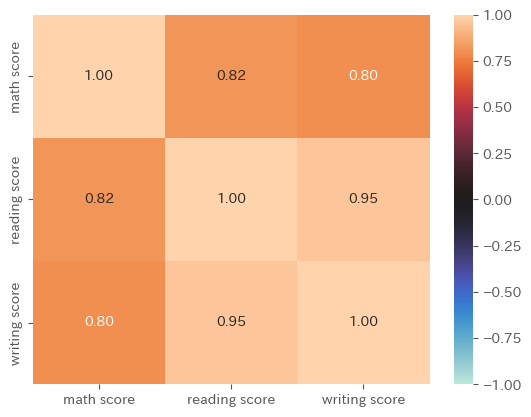

In [69]:
# 相関行列とヒートマップの作成
data_corr_matrix = data['math score'], data['reading score'], data['writing score']
data_corr_matrix = pd.DataFrame( data = data_corr_matrix )
data_corr_matrix = data_corr_matrix.T #行と列を入れ替えている
print(data_corr_matrix)
#相関行列
data_corr_matrix = data_corr_matrix.corr(method = 'pearson')
print(data_corr_matrix)

#ヒートマップ annotは格子の中に数値を書く, fmtは少数第何位まで記載するか指定
sns.heatmap(data_corr_matrix, vmin = -1.0, vmax = 1.0, center = 0, annot = True, fmt = '.2f',
           xticklabels = data_corr_matrix.columns, yticklabels = data_corr_matrix.columns)
plt.show()

### データを分割しない重回帰分析(応答変数を各教科の得点にする)
#### 準備
1. パラメータ間で応答変数に対する影響の大きさを比較したいので量的データを標準化した
2. 質的データはダミー変数に変換した
3. sklearnを使用して線形回帰分析を行った
<br>
#### 結果
- 数学 : writing scoreとgenderが強い影響を与えている
- 読解 : writing scoreが強い影響を与えている
- 筆記 : reading scoreが最も強い影響を与えている

In [74]:
#標準化を行う関数の定義 ddof = 1で不偏標準偏差を求めることができる
def standard_p(p, ddof = 1):
  #平均値の計算
  mean_p = p.mean()
  #標準偏差の計算
  std_p = p.std(ddof = ddof)
  #標準化の計算
  standard_p = (p - mean_p) / (std_p)
  return standard_p

In [77]:
#重回帰分析を行うためにgender、race/ethnicity、test preparationの列をダミー変数にした。それ以外の列は応答変数に対する影響の大きさを比較するために標準化した
data_glm = data.copy()
data_glm['math score'] = standard_p(data['math score'], ddof = 1)
data_glm['reading score'] = standard_p(data['reading score'], ddof = 1)
data_glm['writing score'] = standard_p(data['writing score'], ddof = 1) #データフレームの列をまとめて選択するためには[['','']]を使用する
data_glm = pd.get_dummies(data_glm, dtype = int) #pd.get_dummies(, dtype = int)で1,0の数値に直してくれる
data_glm

,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,0.389828,0.193902,0.391296,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,0.191979,1.426762,1.312612,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
2,1.576922,1.769223,1.641653,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,-1.258913,-0.833482,-1.582952,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,0.653627,0.604855,0.457104,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.445023,2.043192,1.773270,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
996,-0.269668,-0.970467,-0.859061,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
997,-0.467517,0.125409,-0.200978,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
998,0.126030,0.604855,0.588721,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [82]:
#応答変数：数学の点数　　結果:writing scoreとgenderが強い影響を与えている
y_glm_math = pd.DataFrame(data_glm['math score'])
x_glm_math = pd.DataFrame(data_glm.drop('math score', axis = 1))
model_glm_math = LinearRegression()
model_glm_math.fit(x_glm_math, y_glm_math)
#print(x_glm_math.columns)
#print(model_glm_math.coef_.shape) #何行何列か確認する
feature_name = ['reading score', 'writing score', 'gender_female', 'gender_male',
       'race/ethnicity_group A', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E',
       "parental level of education_associate's degree",
       "parental level of education_bachelor's degree",
       'parental level of education_high school',
       "parental level of education_master's degree",
       'parental level of education_some college',
       'parental level of education_some high school', 'lunch_free/reduced',
       'lunch_standard', 'test preparation course_completed',
       'test preparation course_none']
data.coef_math = pd.DataFrame({'feature': feature_name, 'coefficient': model_glm_math.coef_.flatten()}) #1次元配列にする
print(data.coef_math)
print('切片:', model_glm_math.intercept_)
print('回帰係数:', model_glm_math.score(x_glm_math, y_glm_math))


#応答変数：readingの点数　結果:writing scoreが強い影響を与えている
y_glm_reading = pd.DataFrame(data_glm['reading score'])
x_glm_reading = pd.DataFrame(data_glm.drop('reading score', axis = 1))
model_glm_reading = LinearRegression()
model_glm_reading.fit(x_glm_reading, y_glm_reading)
#print(x_glm_reading.columns)
#print(model_glm_reading.coef_.shape) #何行何列か確認する
feature_name = ['math score', 'writing score', 'gender_female', 'gender_male',
       'race/ethnicity_group A', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E',
       "parental level of education_associate's degree",
       "parental level of education_bachelor's degree",
       'parental level of education_high school',
       "parental level of education_master's degree",
       'parental level of education_some college',
       'parental level of education_some high school', 'lunch_free/reduced',
       'lunch_standard', 'test preparation course_completed',
       'test preparation course_none']
data.coef_reading = pd.DataFrame({'feature': feature_name, 'coefficient': model_glm_reading.coef_.flatten()}) #1次元配列にする
print(data.coef_reading)
print('切片:', model_glm_reading.intercept_)
print('回帰係数:', model_glm_reading.score(x_glm_reading, y_glm_reading))


#応答変数：writingの点数 　結果:reading scoreが最も強い影響を与えている
y_glm_writing = pd.DataFrame(data_glm['writing score'])
x_glm_writing = pd.DataFrame(data_glm.drop('writing score', axis = 1))
model_glm_writing = LinearRegression()
model_glm_writing.fit(x_glm_writing, y_glm_writing)
#print(x_glm_writing.columns)
#print(model_glm_writing.coef_.shape) #何行何列か確認する
feature_name = ['math score', 'reading score', 'gender_female', 'gender_male',
       'race/ethnicity_group A', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E',
       "parental level of education_associate's degree",
       "parental level of education_bachelor's degree",
       'parental level of education_high school',
       "parental level of education_master's degree",
       'parental level of education_some college',
       'parental level of education_some high school', 'lunch_free/reduced',
       'lunch_standard', 'test preparation course_completed',
       'test preparation course_none']
data.coef_writing = pd.DataFrame({'feature': feature_name, 'coefficient': model_glm_writing.coef_.flatten()}) #1次元配列にする
print(data.coef_writing)
print('切片:', model_glm_writing.intercept_)
print('回帰係数:', model_glm_writing.score(x_glm_writing, y_glm_writing))

                                           feature   coefficient
0                                    reading score  2.560935e-01
1                                    writing score  6.990499e-01
2                                    gender_female -3.656662e+12
3                                      gender_male -3.656662e+12
4                           race/ethnicity_group A  6.596427e+12
5                           race/ethnicity_group B  6.596427e+12
6                           race/ethnicity_group C  6.596427e+12
7                           race/ethnicity_group D  6.596427e+12
8                           race/ethnicity_group E  6.596427e+12
9   parental level of education_associate's degree  1.103737e+13
10   parental level of education_bachelor's degree  1.103737e+13
11         parental level of education_high school  1.103737e+13
12     parental level of education_master's degree  1.103737e+13
13        parental level of education_some college  1.103737e+13
14    parental level of e

/var/folders/2n/k04q38yx087g0pz_q6w7gfd40000gn/T/ipykernel_17327/1418048641.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.coef_math = pd.DataFrame({'feature': feature_name, 'coefficient': model_glm_math.coef_.flatten()}) #1次元配列にする
/var/folders/2n/k04q38yx087g0pz_q6w7gfd40000gn/T/ipykernel_17327/1418048641.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.coef_reading = pd.DataFrame({'feature': feature_name, 'coefficient': model_glm_reading.coef_.flatten()}) #1次元配列にする
/var/folders/2n/k04q38yx087g0pz_q6w7gfd40000gn/T/ipykernel_17327/1418048641.py:70: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.coef_writing = pd

### データを分割する重回帰分析
##### 学習用データとテスト用データに分割することでモデルの良さを確認することができる
#### 結果   
どの教科のモデルも予測値と実測値の決定係数が0.8以上になっている。    
これからデータを増やしていけば、より良いモデルになると考えられる。 

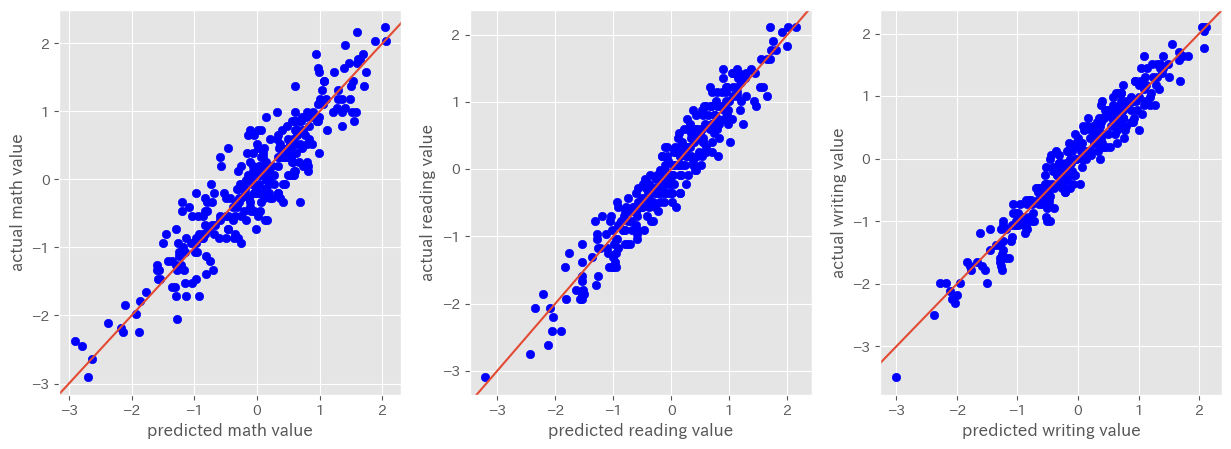

mathの決定係数 : 0.8475186037524444
readingの決定係数 : 0.9265817683312054
writingの決定係数 : 0.9419079692952169


In [89]:
#データ分割ありの重回帰分析　test用データ30％ 
# math
from sklearn.model_selection import train_test_split
y_glm_math = pd.DataFrame(data_glm['math score'])
x_glm_math = pd.DataFrame(data_glm.drop('math score', axis = 1))
x_math_train, x_math_test, y_math_train, y_math_test = train_test_split(x_glm_math, y_glm_math, test_size = 0.3, random_state = 0)
lr = LinearRegression()
lr.fit(x_math_train, y_math_train)
y_math_pred = lr.predict(x_math_test)
# y_math_pred.shape
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].scatter(y_math_pred, y_math_test, color = 'blue')
ax[0].axline((0,0), slope = 1)
ax[0].set_xlabel('predicted math value')
ax[0].set_ylabel('actual math value')

#reading
y_glm_reading = pd.DataFrame(data_glm['reading score'])
x_glm_reading = pd.DataFrame(data_glm.drop('reading score', axis = 1))
x_reading_train, x_reading_test, y_reading_train, y_reading_test = train_test_split(x_glm_reading, y_glm_reading, test_size = 0.3, random_state = 0)
lr = LinearRegression()
lr.fit(x_reading_train, y_reading_train)
y_reading_pred = lr.predict(x_reading_test)
# y_reading_pred.shape
ax[1].scatter(y_reading_pred, y_reading_test, color = 'blue')
ax[1].axline((0,0), slope = 1)
ax[1].set_xlabel('predicted reading value')
ax[1].set_ylabel('actual reading value')

# writing
y_glm_writing = pd.DataFrame(data_glm['writing score'])
x_glm_writing = pd.DataFrame(data_glm.drop('writing score', axis = 1))
x_writing_train, x_writing_test, y_writing_train, y_writing_test = train_test_split(x_glm_writing, y_glm_writing, test_size = 0.3, random_state = 0)
lr = LinearRegression()
lr.fit(x_writing_train, y_writing_train)
y_writing_pred = lr.predict(x_writing_test)
# y_writing_pred.shape
ax[2].scatter(y_writing_pred, y_writing_test, color = 'blue')
ax[2].axline((0,0), slope = 1)
ax[2].set_xlabel('predicted writing value')
ax[2].set_ylabel('actual writing value')
plt.show()

from sklearn.metrics import r2_score
r2_math_test = r2_score(y_math_test, y_math_pred)
print(f"mathの決定係数 : {r2_math_test}")

r2_reading_test = r2_score(y_reading_test, y_reading_pred)
print(f"readingの決定係数 : {r2_reading_test}")

r2_writing_test = r2_score(y_writing_test, y_writing_pred)
print(f"writingの決定係数 : {r2_writing_test}")

#### クラスター分析
生徒の成績をクラスターに分け、シルエット図でクラスター数の是非を評価した

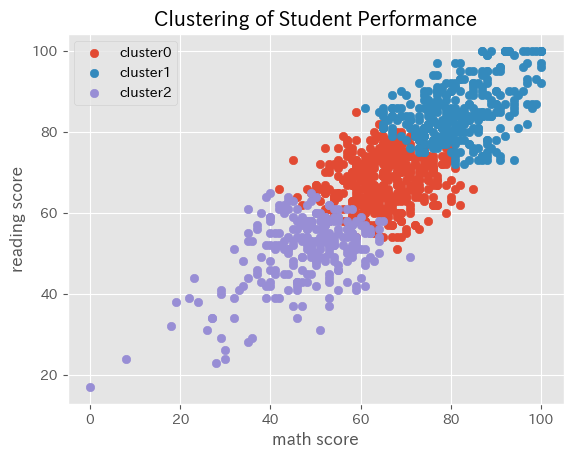

In [95]:
#クラスタリング分析 k-means
from sklearn.cluster import KMeans
X = data[['math score', 'reading score', 'writing score']]
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=30) # クラスタ数（K）を3に設定 　n_init:kmeansを実行する回数
data['cluster'] = kmeans.fit_predict(X)

# クラスタごとの散布図（数学 vs 読解）
fig, ax = plt.subplots()
ax.set_xlabel('math score')
ax.set_ylabel('reading score')
ax.set_title("Clustering of Student Performance")
for i in np.sort(data['cluster'].unique()):
    ax.scatter(data[data['cluster']==i]['math score'], data[data['cluster']==i]['reading score'], label=f'cluster{i}')
plt.legend()
plt.show()

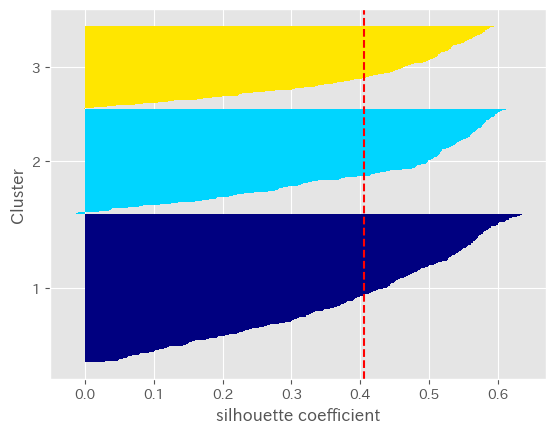

In [98]:
#シルエット図を作成し、クラスター数が適切かどうか確認する
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(data['cluster'])   
n_clusters=cluster_labels.shape[0]     #配列の長さを返す。つまりここでは n_clustersで指定した3となる

# シルエット係数を計算
silhouette_vals = silhouette_samples(X, data['cluster'], metric='euclidean')  #サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[data['cluster']==c]      #cluster_labelsには 0,1,2が入っている
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              #サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
        color = cm.jet(float(i)/n_clusters)               #色の値を作る
        plt.barh(range(y_ax_lower,y_ax_upper),            #水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               #棒の幅（1サンプルを表す）
                         height=1.0,                      #棒の高さ
                         edgecolor='none',                #棒の端の色
                         color=color)                     #棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          #クラスタラベルの表示位置を追加
        y_ax_lower += len(c_silhouette_vals)              #底辺の値に棒の幅を追加
        
silhouette_avg = np.mean(silhouette_vals)                 #シルエット係数の平均値
plt.axvline(silhouette_avg,color="red",linestyle="--")    #係数の平均値に破線を引く 
plt.yticks(yticks,cluster_labels + 1)                     #クラスタレベルを表示
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()